# UnhapPy Earth 

Étude de cas : Analyse du réchauffement climatique 



## Initialisation du notebook
* Connexion au Google Drive
* Import des packages

In [139]:
# Montage du Google Drive

from google.colab import drive
drive.mount('/content/drive')

#%run '/content/drive/MyDrive/Colab Notebooks/Fonctions.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
# Import des packages

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

## Définition de fonctions

Cette section décrit rapidement les fonctions définies dans ce fichier.


### Fonction `read_txt_file`

Fonction permettant de lire un fichier de mesures, de récupérer les températures de références et anomalies, puis de calculer les valeurs de températures absolues. 

Calcul des températures absolues: pour calculer la température absolue d’un mois donné, il faut ajouter la valeur d’anomalie correspondant au même mois dans la liste de températures de référence (période 1951 - 1980) citée en en-tête. 

La fonction renvoie un DataFrame avec les colonnes `date`, `year`, `month`, `ano`, `abs`, `uncert`.


In [141]:
# Définition de la fonction read_text_file

def read_txt_file(file_in: str) -> pd.DataFrame:
    """
    Read a file, extract reference temperatures and anomalies, compute
    absolute temperatures, and return a complete dataframe.
    """
    with open(file_in) as f:
        lines = f.readlines()
    
    temps = pd.DataFrame()
    refs = []
    temp_re = re.compile('^\s+(?P<year>\S+)\s+(?P<month>\S+)\s+(?P<ano>\S+)\s+(?P<uncert>\S+)\s+')
    ref_all_re = re.compile('^%%?\s+((?P<month>[\d.-]+)\s+)+$')
    for line in lines:
        # Check if line is a data line
        m = temp_re.match(line)
        if m:
            record = m.groups()
            record_s = pd.DataFrame(record)
            temps = pd.concat([temps, record_s], axis=1)
            continue
        # Check if line is a reference 
        refs_m = ref_all_re.match(line)
        if refs_m and len(refs) == 0:
            refs = [ float(x) for x in re.findall(r'[\d.-]+', refs_m.group(0)) ]
    
    # Reformat, set column names and types.
    temps = temps.T
    temps.columns = ['year', 'month', 'ano', 'uncert']
    temps['year'] = temps['year'].astype(int)
    temps['month'] = temps['month'].astype(int)
    temps['ano'] = temps['ano'].astype(float)
    temps['uncert'] = temps['uncert'].astype(float)
    
    # Compute absolute temperatures.
    temps['abs'] = temps.agg(lambda x: x['ano'] + refs[int(x['month'])-1], axis=1)
    
    # Prevent floating point black magic by rounding.
    temps.round({'abs': 3})
    
    # Set 'date' column
    temps['date'] = pd.to_datetime(temps['year'].map(str) + '-' + temps['month'].map(str) + '-15')
    
    return temps

# Test de la fonction, à décommenter au besoin.
#df = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Complete_TAVG_complete.txt')

### Fonctions de visualisation

Définition de fonctions de plotting, par mois ou par an, pour une ou plusieurs régions. 

In [142]:
# Définition d'une fonction pour l'affichage d'un graphe montrant l'évolution des températures par 
# mois pour un DF donné, et la moyenne glissante sur 12 mois des températures :

def plot_month(df, title) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by month) and y = absolute temperature.
  Add a cmap to colorize the scatter based on y value.
  Plot 12-months moving average temperature.
  """
  plt.figure(figsize=(18,6))
  plt.grid(color='grey', alpha=0.2)
  plt.plot(df['date'], df['abs'], c='lightgrey', zorder=1)
  plt.scatter(df['date'], df['abs'], c=df['abs'], cmap='jet', vmin=-40.5, vmax=40, s=15, zorder=2,
              label='Moyennes mensuelles')
  
  plt.plot(df['date'], df['mov_average'], color='r', linewidth=2, label='Moyenne glissante sur 12 mois')

  plt.colorbar()
  plt.xlabel('Date (par mois)')
  plt.ylabel('Température absolue en °C')
  plt.legend()
  plt.title(title)
  plt.show()

In [143]:
# Définition d'une fonction pour l'affichage d'un graphe montrant l'évolution des températures par 
# an pour un DF donné, avec ou sans marge d'incertitude :

def plot_year(df, title, show_uncert=False) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by year) and y = absolute temperature.
  The 'show_uncert' parameter allows, if True, to display the uncertainty margin.
  Add a cmap to colorize the scatter plot based on y value, when uncertainty is not plotted.
  """
  temp_year = df[['year', 'abs', 'uncert']].groupby('year').mean().reset_index()
  plt.figure(figsize=(18,6))
  plt.grid(color='grey', alpha=0.2)
  plt.plot(temp_year['year'], temp_year['abs'], c='grey', zorder=1)
  
  if show_uncert==True :
    plt.scatter(temp_year['year'], temp_year['abs'],
              edgecolor='none', zorder=2)
    plt.fill_between(temp_year['year'], 
                 temp_year['abs'] - temp_year['uncert'], 
                 temp_year['abs'] + temp_year['uncert'],
                 color='#D3D3D3', zorder=0)
    
  else :
    plt.scatter(temp_year['year'], temp_year['abs'], c=temp_year['abs'],
            cmap='jet', vmin=-40.5, vmax=40, edgecolor='none', zorder=2)
    plt.colorbar()

  plt.xlabel('Date (par annnée)')
  plt.ylabel('Température absolue en °C')
  plt.title(title)
  plt.show()

In [144]:
# Définition d'une fonction pour l'affichage de plusieurs graphe montrant l'évolution des
# températures par an sur plusieurs régions :

def mult_plot_year(df_dict, title) :
  """
  Display multiple plots and a scatter plots from a DFs dictionary, with x = date (by year) and y = absolute temperature.
  Add a cmap to colorize the scatter plots based on y value.
  """
  plt.figure(figsize=(18,6))
  for key, df in df_dict.items() :
    temp_year = df[['year', 'abs']].groupby('year').mean().reset_index()
    plt.plot(temp_year['year'], temp_year['abs'], c='lightgrey', zorder=1)
    plt.scatter(temp_year['year'], temp_year['abs'], c=temp_year['abs'], label=key,
              cmap='jet', vmin=-40.5, vmax=40, edgecolor='none', zorder=2)
  plt.grid(color='grey', alpha=0.2)
  plt.xlabel('Date (par annnée)')
  plt.ylabel('Température absolue en °C')
  plt.colorbar()
  plt.title(title)
  plt.legend()
  plt.show()

## Contexte et objectifs

Notre objectif est de proposer une analyse du réchauffement climatique,  en répondant aux problématiques suivantes :
- Pouvons-nous confirmer grâce aux données le phénomène de changement climatique ? Le réchauffement est-il réellement observable ? 
- Quand le phénomène apparaît-il ? De manière soudaine ou graduelle ? Au même moment sur l’ensemble du globe ?
- Son évolution est-elle uniforme à travers le monde ou certaines zones sont-elles plus impactées que d’autres ?
- Le CO2 serait, parmi l’ensemble des gaz à effet de serre émis, la principale cause du réchauffement de la planète. Existe-t-il une forte corrélation entre les émissions de CO2 et l’évolution des températures ?
- La montée du niveau des mers et océans serait une des conséquences majeures du changement climatique. A nouveau, pouvons-nous confirmer la corrélation entre augmentation de la température et hausse du niveau des océans ?




## Sources et détails des data sets

Afin d’atteindre nos objectifs, nous nous basons sur les Data Sets disponibles sur le site [Berkeley Earth](http://berkeleyearth.org/data/). Cette organisation américaine indépendante se concentre sur la science des données environnementales. Recoupant elle-même plusieurs sources, notamment l'analyse [GISTEMP](https://data.giss.nasa.gov/gistemp/) réalisée sous l'égide de la NASA, elle fournit un ensemble de Data Sets actualisés, complets, avec une large quantité d’information (au total, plus de 19 millions d’observations depuis 46 000 stations météo).

Les Data Sets que nous utilisons pour nos analyses sont les suivants :

*   Températures globales :
  - `Land_and_Ocean_complete_1.txt` : liste des températures globales moyennes sur terres et sur mer. \
    Format de lecture : fonction read_txt_file()
  - `Complete_TAVG_complete.txt` : liste des températures globales moyennes sur terres. \
    Format de lecture : fonction read_txt_file()

*   Températures par hemisphères :
  - `northern-hemisphere-TAVG-Trend.txt` : liste des températures moyennes par hémisphère (nord) \
    Format de lecture : fonction read_txt_file()fonction read_txt_file()
  - `southern-hemisphere-TAVG-Trend.txt` : liste des températures moyennes par hémisphère (sud) \
    Format de lecture : fonction read_txt_file()fonction read_txt_file()

*   Températures par pays :
  - `Sets_by_country` : liste des températures moyennes par pays. \
    Format de lecture : fonction read_txt_file()fonction read_txt_file()

Chaque jeu de données contient des températures moyennes pour la zone géographique concernée, par mois, avec incertitudes.

## Description des data sets

Il s’agit de fichiers « .txt », chacun d’entre eux correspondant à une région, quel que soit son ordre de grandeur (totalité du globe, hémisphère, continent ou pays). Ils sont tous construits de la même manière.
Chaque fichier contient en en-tête une description, dont un élément crucial : 

Une liste de 12 **températures de référence** absolues mensuelles et leur incertitude sur une période fixe de 30 ans, de janvier 1951 à décembre 1980. Cette période a été retenue d'une part pour la fiabilité et la complétude des observations effectuées, mais surtout car elle représente une sorte de médiane sur l'ensemble du dataset : globalement, la moitié des données seront situées en-dessous de ces valeurs, l'autre moitié au-dessus. Ces références nous permettront de calculer les températures en valeurs absolues.

Ensuite, un tableau donne le détail des résultats moyens sous forme d’anomalies, ou **températures relatives**, assorties de leur incertitude, observés par mois pour la région donnée, pour une période allant de 1750 au plus tôt, et jusqu’en 2021.
Plus d'information concernant ce mesurement et l'intérêt de raisonner en termes d'anomalies [ici](https://data.giss.nasa.gov/gistemp/faq/abs_temp.html).

* L’anomalie de température est une value relative, exprimée en degrés Celsius correspondant à l’écart, positif ou négatif, entre la température mesurée et la température moyenne de référence correspondante.
* L’incertitude est la dispersion liée à différents facteurs, notamment de sous-échantillonnage statistique et spatial, influant *in fine* sur la qualité de la mesure. Elle représente l'intervalle de confiance à 95 %.

Les données sont réparties sur 12 colonnes.
Les quatre premières colonnes fournissent l’information suivante : l’année, le mois de l’année, l’anomalie de température moyenne estimée pour ce mois et son incertitude. 

Les huit dernières colonnes rapportent les anomalies et incertitudes sous la forme de moyennes glissantes annuelles, quinquennales, décennales et vicennales, centrées sur le mois considéré. Par exemple, la moyenne annuelle de janvier à décembre 1950 est rapportée à juin 1950, ce qui explique la présence de « NaNs » en début et fin de ces colonnes dans les Data Sets. Dans un premier temps nous n'utiliserons pas ces moyennes glissantes.

# Analyse exploratoire des Data Sets

## Températures globales

Températures moyennes pour l'ensemble du globe :
* à la surface des zones terriennes et océaniques ;
* à la surface des zones terriennes uniquement.


### Zones terriennes et océaniques

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction `read_txt_file()`, pour les températures globales sur terres et océans.

In [145]:
global_land_ocean = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Land_and_Ocean_complete_1.txt')
global_land_ocean.head()

,year,month,ano,uncert,abs,date
0,1850,1,-0.760,0.435,11.470,1850-01-15
0,1850,2,-0.207,0.420,12.233,1850-02-15
0,1850,3,-0.370,0.353,12.690,1850-03-15
0,1850,4,-0.605,0.284,13.375,1850-04-15
0,1850,5,-0.632,0.293,14.318,1850-05-15


Description du type des colonnes du jeu de données :

In [146]:
global_land_ocean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064 entries, 0 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    2064 non-null   int64         
 1   month   2064 non-null   int64         
 2   ano     2064 non-null   float64       
 3   uncert  2064 non-null   float64       
 4   abs     2064 non-null   float64       
 5   date    2064 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 112.9 KB


Description statistique des colonnes du jeu de données :

In [147]:
global_land_ocean.describe()

,year,month,ano,uncert,abs
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,1935.500000,6.500000,-0.009375,0.125572,14.094791
std,49.663316,3.452889,0.406460,0.083548,1.395532
min,1850.000000,1.000000,-0.999000,0.029000,11.231000
25%,1892.750000,3.750000,-0.297000,0.049000,12.805750
50%,1935.500000,6.500000,-0.093000,0.116500,14.100000
75%,1978.250000,9.250000,0.193250,0.165000,15.398250
max,2021.000000,12.000000,1.335000,0.555000,16.916000


Recherche de données manquantes : 

In [148]:
global_land_ocean.isna().sum(axis=0)

year      0
month     0
ano       0
uncert    0
abs       0
date      0
dtype: int64

Le DF Global Land & Ocean est complet, et ne contient aucun NaN.

Calcul de la moyenne mobile des valeurs absolues :

Les moyennes mobiles sont essentiellement un outil de suivi de tendance. Pour cet objectif nous allons creer une colonne 'mov_average' qui indique la valeur de la moyenne de 12 derniers mois a partir de la ligne dans laquelle est apparait.

In [149]:
global_land_ocean['mov_average'] = global_land_ocean['abs'].rolling(12).mean()
global_land_ocean.head(15)

,year,month,ano,uncert,abs,date,mov_average
0,1850,1,-0.760,0.435,11.470,1850-01-15,NaN
0,1850,2,-0.207,0.420,12.233,1850-02-15,NaN
0,1850,3,-0.370,0.353,12.690,1850-03-15,NaN
0,1850,4,-0.605,0.284,13.375,1850-04-15,NaN
0,1850,5,-0.632,0.293,14.318,1850-05-15,NaN
0,1850,6,-0.350,0.310,15.320,1850-06-15,NaN
0,1850,7,-0.175,0.273,15.775,1850-07-15,NaN
0,1850,8,-0.167,0.288,15.613,1850-08-15,NaN
0,1850,9,-0.423,0.276,14.767,1850-09-15,NaN
0,1850,10,-0.584,0.319,13.676,1850-10-15,NaN


Dans un premier temps, nous voulons visualiser l'évolution des températures sur la durée totale du jeu de données. Comme les données sont mensuelles, nous pouvons observer des variations saisonales correspondant à chaque année.

Nous utilisons la fonction `plot_month` :

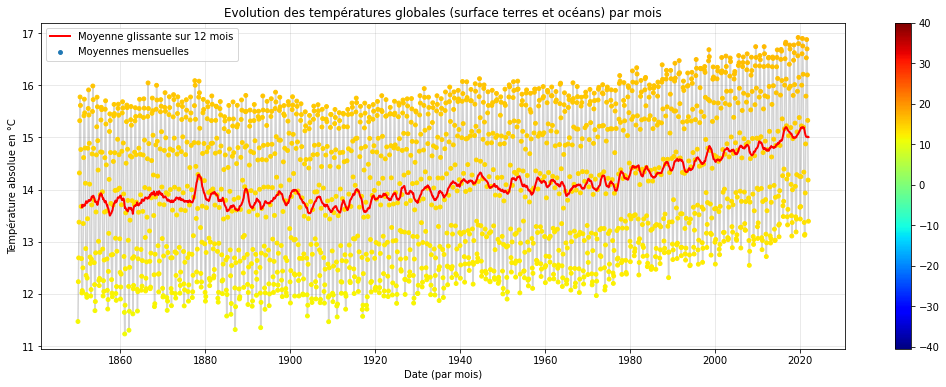

In [150]:
# Utilisation de la fonction plot_month pour le DF global, terres et océans :

plot_month(global_land_ocean, 'Evolution des températures globales (surface terres et océans) par mois')

A présent, visualisons l'évolution des températures moyennes annuelles, en affichant également la marge d'incertitude.

Nous utilisons la fonction `plot_year` :

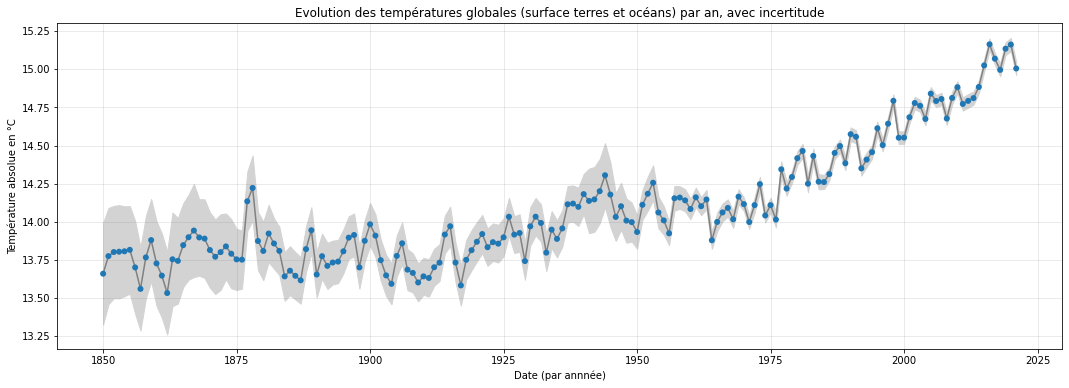

In [151]:
# plot_year pour le DF global, terres et océans :

plot_year(global_land_ocean, 
          'Evolution des températures globales (surface terres et océans) par an, avec incertitude',
          show_uncert=True)

### Zones terriennes uniquement

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction `read_txt_file()`, pour les températures globales sur terres uniquement.

In [152]:
global_land_only = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Complete_TAVG_complete.txt')
global_land_only.head()

,year,month,ano,uncert,abs,date
0,1750,1,-0.490,3.240,2.110,1750-01-15
0,1750,2,-1.029,3.620,2.171,1750-02-15
0,1750,3,0.211,3.079,5.501,1750-03-15
0,1750,4,-0.166,1.671,8.114,1750-04-15
0,1750,5,-1.589,2.514,9.681,1750-05-15


Description du type des colonnes du jeu de données :

In [153]:
global_land_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    3265 non-null   int64         
 1   month   3265 non-null   int64         
 2   ano     3264 non-null   float64       
 3   uncert  3262 non-null   float64       
 4   abs     3264 non-null   float64       
 5   date    3265 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 178.6 KB


Description statistique des colonnes du jeu de données :

In [154]:
global_land_only.describe()

,year,month,ano,uncert,abs
count,3265.000000,3265.000000,3264.000000,3262.000000,3264.000000
mean,1885.541807,6.498315,-0.265392,0.902632,8.329213
std,78.555437,3.453394,0.961144,1.043254,4.330287
min,1750.000000,1.000000,-6.018000,0.022000,-2.423000
25%,1818.000000,3.000000,-0.701250,0.173000,4.290250
50%,1886.000000,6.000000,-0.197000,0.385000,8.561000
75%,1954.000000,9.000000,0.244250,1.386250,12.425500
max,2022.000000,12.000000,5.531000,6.521000,17.780000


Recherche et identification des données manquantes : 

In [155]:
global_land_only.isna().sum(axis=0)

year      0
month     0
ano       1
uncert    3
abs       1
date      0
dtype: int64

Nous remarcons un NaN dans la colonne 'ano', un dans 'abs' et trois NaN dans la colonne 'uncert'.

Pour remplir les NaN, la méthode que nous considérons la plus adéquate concernant le sujet de températures est l’interpolation linéaire - la technique de détermination des valeurs des fonctions de tout point intermédiaire lorsque les valeurs de deux points adjacents sont connues.  

In [156]:
global_land_only = global_land_only.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN:

In [157]:
global_land_only=global_land_only.reset_index()
global_land_only.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

In [158]:
global_land_only.head()

,date,year,month,ano,uncert,abs
0,1750-01-15,1750,1,-0.490,3.240,2.110
1,1750-02-15,1750,2,-1.029,3.620,2.171
2,1750-03-15,1750,3,0.211,3.079,5.501
3,1750-04-15,1750,4,-0.166,1.671,8.114
4,1750-05-15,1750,5,-1.589,2.514,9.681


Calcul de la moyenne mobile des valeurs absolues :

In [159]:
global_land_only['mov_average']=global_land_only['abs'].rolling(12).mean()
global_land_only.head(15)

,date,year,month,ano,uncert,abs,mov_average
0,1750-01-15,1750,1,-0.490,3.240,2.110,NaN
1,1750-02-15,1750,2,-1.029,3.620,2.171,NaN
2,1750-03-15,1750,3,0.211,3.079,5.501,NaN
3,1750-04-15,1750,4,-0.166,1.671,8.114,NaN
4,1750-05-15,1750,5,-1.589,2.514,9.681,NaN
5,1750-06-15,1750,6,-1.050,1.078,12.370,NaN
6,1750-07-15,1750,7,-0.158,2.715,14.142,NaN
7,1750-08-15,1750,8,0.197,1.623,14.037,NaN
8,1750-09-15,1750,9,-1.084,1.448,10.966,NaN
9,1750-10-15,1750,10,-2.136,2.254,7.074,NaN


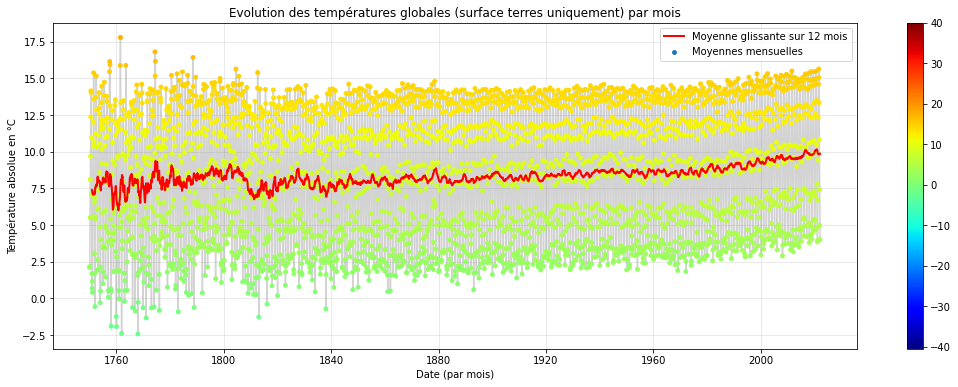

In [160]:
# Utilisation de la fonction plot_month pour le DF global, terres uniquement :

plot_month(global_land_only, 'Evolution des températures globales (surface terres uniquement) par mois')

Nous visualisons également les températures moyennes par années, avec affichage des incertitudes :

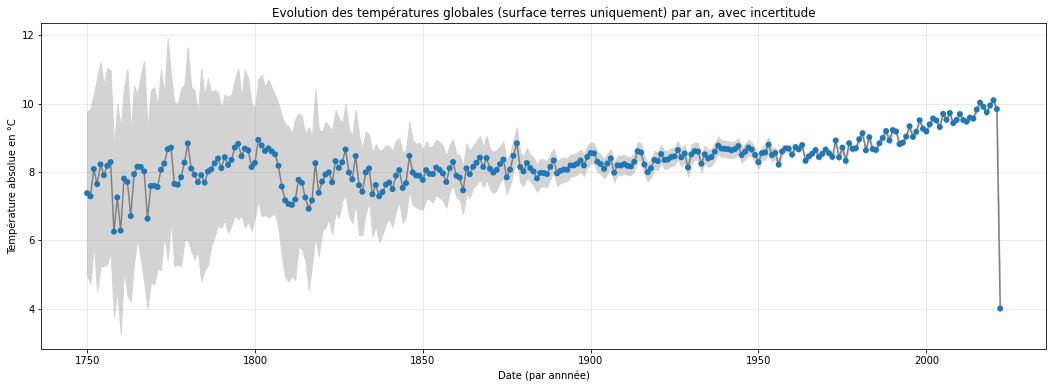

In [161]:
plot_year(global_land_only, 
          'Evolution des températures globales (surface terres uniquement) par an, avec incertitude',
          show_uncert=True)

Remarquons que dans les 2 cas, la marge d'incertitude s'amincit au cours du temps. La qualité des mesures et le nombre d'observations augmentent et améliorent grandement la fiabilité des données.

### Affichage comparé

Affichons côte-à-côte ces 2 graphes, sans l'incertitude :

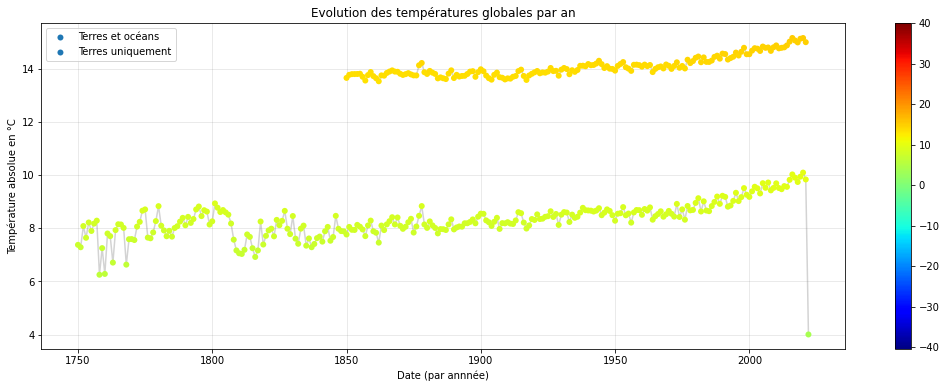

In [162]:
global_dict = {"Terres et océans": global_land_ocean, "Terres uniquement": global_land_only}
mult_plot_year(global_dict, "Evolution des températures globales par an")

# TODO : Je cherche comment différencier les couleurs dans la légende (qui sinon n'a pas d'intérêt)


Nous pouvons faire 2 remarques :
* La tendance à la hausse est nette dès 1800 pour les terres et dès les premières mesures retenues pour les terres et océans.
* Les moyennes sont beaucoup plus élevées (6°C env.) dès lors qu'elles comprennent les mesures à la surface des océans. 

## Températures par hémisphère

Températures moyennes à la surface des zones terriennes pour chaque hémisphère :

### Hémisphère Nord

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction `read_txt_file()`, pour les températures globales sur terres dans l'hémisphère **Nord**.

In [163]:
north_hem = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Sets_by_hemisphere/northern-hemisphere-TAVG-Trend.txt')
north_hem.head()

,year,month,ano,uncert,abs,date
0,1840,1,0.447,1.333,-1.613,1840-01-15
0,1840,2,-0.821,1.100,-0.861,1840-02-15
0,1840,3,-1.050,1.503,3.520,1840-03-15
0,1840,4,-0.455,0.622,9.895,1840-04-15
0,1840,5,-0.002,0.829,15.738,1840-05-15


Description du type des colonnes du jeu de données :

In [164]:
north_hem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    2172 non-null   int64         
 1   month   2172 non-null   int64         
 2   ano     2171 non-null   float64       
 3   uncert  2171 non-null   float64       
 4   abs     2171 non-null   float64       
 5   date    2172 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 118.8 KB


Description statistique des colonnes du jeu de données :

In [165]:
north_hem.describe()

,year,month,ano,uncert,abs
count,2172.000000,2172.000000,2171.000000,2171.000000,2171.000000
mean,1930.000000,6.500000,-0.008731,0.281514,10.115351
std,52.261434,3.452847,0.690087,0.265338,8.329924
min,1840.000000,1.000000,-2.322000,0.042000,-4.382000
25%,1885.000000,3.750000,-0.410500,0.118000,2.664000
50%,1930.000000,6.500000,-0.049000,0.167000,10.649000
75%,1975.000000,9.250000,0.335500,0.349500,18.400000
max,2020.000000,12.000000,2.883000,2.518000,22.587000


Recherche et identification des données manquantes : 

In [166]:
north_hem.isna().sum(axis=0)

year      0
month     0
ano       1
uncert    1
abs       1
date      0
dtype: int64

Nous remarcons un NaN dans la colonne 'ano', un dans 'uncert' et un dans 'abs'. 
Preil que dans le data set precedent, nous utilisons l'interpolation linéaire:

In [167]:
north_hem = north_hem.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN:

In [168]:
north_hem = north_hem.reset_index()
north_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

In [169]:
north_hem.head()

,date,year,month,ano,uncert,abs
0,1840-01-15,1840,1,0.447,1.333,-1.613
1,1840-02-15,1840,2,-0.821,1.100,-0.861
2,1840-03-15,1840,3,-1.050,1.503,3.520
3,1840-04-15,1840,4,-0.455,0.622,9.895
4,1840-05-15,1840,5,-0.002,0.829,15.738


Calcul de la moyenne mobile des valeurs absolues :

In [170]:
north_hem['mov_average'] = north_hem['abs'].rolling(12).mean()
north_hem.head(15)

,date,year,month,ano,uncert,abs,mov_average
0,1840-01-15,1840,1,0.447,1.333,-1.613,NaN
1,1840-02-15,1840,2,-0.821,1.100,-0.861,NaN
2,1840-03-15,1840,3,-1.050,1.503,3.520,NaN
3,1840-04-15,1840,4,-0.455,0.622,9.895,NaN
4,1840-05-15,1840,5,-0.002,0.829,15.738,NaN
5,1840-06-15,1840,6,-0.079,0.632,19.591,NaN
6,1840-07-15,1840,7,0.233,0.668,21.553,NaN
7,1840-08-15,1840,8,-0.721,0.905,19.489,NaN
8,1840-09-15,1840,9,-1.003,0.680,15.627,NaN
9,1840-10-15,1840,10,-1.830,0.730,9.160,NaN


Utilisons la même méthodologie que précédemment pour visualiser ces données.

La fonction `plot_month` permet d'afficher les données mensuelles, soumises à variations saisonales :

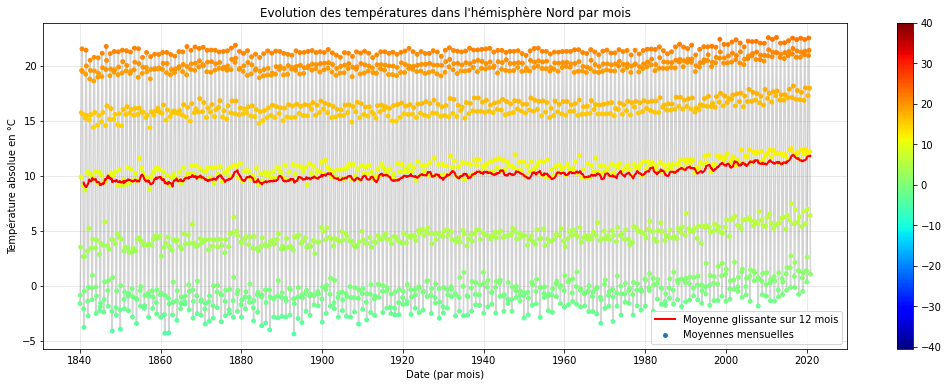

In [171]:
# Utilisation de la fonction get_plot_month pour le DF north_hem :

plot_month(north_hem, "Evolution des températures dans l'hémisphère Nord par mois")

Fonction `plot_year`:

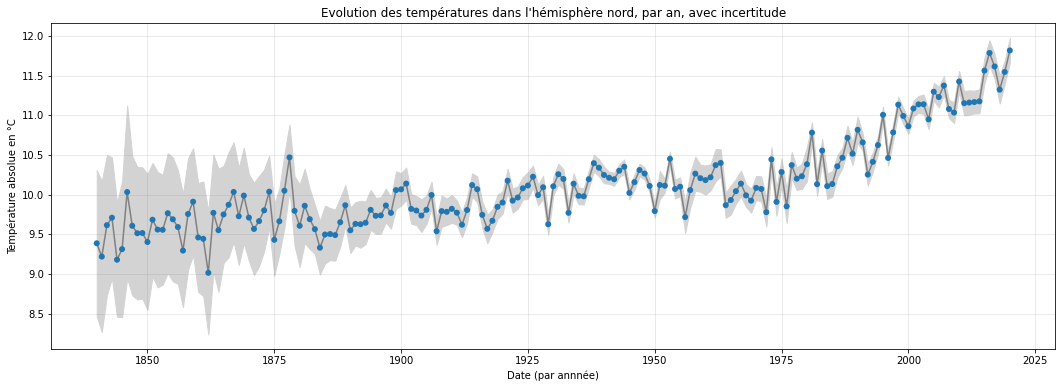

In [172]:
# plot_year pour le DF north_hem :

plot_year(north_hem, 
          "Evolution des températures dans l'hémisphère nord, par an, avec incertitude",
          show_uncert=True)

### Hémisphère Sud

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction read_txt_file(), pour les températures globales sur terres dans l'hémisphère **Sud**.

In [173]:
south_hem = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Sets_by_hemisphere/southern-hemisphere-TAVG-Trend.txt')
south_hem.head()

,year,month,ano,uncert,abs,date
0,1880,8,0.323,0.693,13.823,1880-08-15
0,1880,9,-0.712,0.653,14.768,1880-09-15
0,1880,10,-0.688,0.692,16.722,1880-10-15
0,1880,11,-0.206,0.696,19.094,1880-11-15
0,1880,12,-0.357,0.726,20.083,1880-12-15


Description du type des colonnes du jeu de données :

In [174]:
south_hem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    1685 non-null   int64         
 1   month   1685 non-null   int64         
 2   ano     1683 non-null   float64       
 3   uncert  1683 non-null   float64       
 4   abs     1683 non-null   float64       
 5   date    1685 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 92.1 KB


Description statistique des colonnes du jeu de données :

In [175]:
south_hem.describe()

,year,month,ano,uncert,abs
count,1685.000000,1685.000000,1683.000000,1683.000000,1683.000000
mean,1950.290801,6.510386,0.037915,0.286562,16.885182
std,40.547306,3.454065,0.514970,0.165932,2.954155
min,1880.000000,1.000000,-1.380000,0.064000,11.522000
25%,1915.000000,4.000000,-0.321500,0.131000,14.148500
50%,1950.000000,7.000000,-0.031000,0.276000,17.080000
75%,1985.000000,10.000000,0.340000,0.400000,19.658000
max,2020.000000,12.000000,1.709000,0.830000,22.005000


Recherche et identification des données manquantes :

In [176]:
south_hem.isna().sum(axis=0)

year      0
month     0
ano       2
uncert    2
abs       2
date      0
dtype: int64

Nous remarcons deux NaNs dans la colonnes 'ano', deux dans 'uncert' et deux dans 'abs'. Preil que dans le data set precedent, nous utilisons l'interpolation linéaire:

In [177]:
south_hem = south_hem.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN :

In [178]:
south_hem = south_hem.reset_index()
south_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

In [179]:
south_hem.head()

,date,year,month,ano,uncert,abs
0,1880-08-15,1880,8,0.323,0.693,13.823
1,1880-09-15,1880,9,-0.712,0.653,14.768
2,1880-10-15,1880,10,-0.688,0.692,16.722
3,1880-11-15,1880,11,-0.206,0.696,19.094
4,1880-12-15,1880,12,-0.357,0.726,20.083


Calcul de la moyenne mobile des valeurs absolues :

In [180]:
south_hem['mov_average'] = south_hem['abs'].rolling(12).mean()
south_hem.head(15)

,date,year,month,ano,uncert,abs,mov_average
0,1880-08-15,1880,8,0.323,0.693,13.823,NaN
1,1880-09-15,1880,9,-0.712,0.653,14.768,NaN
2,1880-10-15,1880,10,-0.688,0.692,16.722,NaN
3,1880-11-15,1880,11,-0.206,0.696,19.094,NaN
4,1880-12-15,1880,12,-0.357,0.726,20.083,NaN
5,1881-01-15,1881,1,-0.395,0.703,20.415,NaN
6,1881-02-15,1881,2,-0.546,0.650,19.554,NaN
7,1881-03-15,1881,3,-0.407,0.620,18.353,NaN
8,1881-04-15,1881,4,-0.262,0.662,16.338,NaN
9,1881-05-15,1881,5,0.065,0.687,14.635,NaN


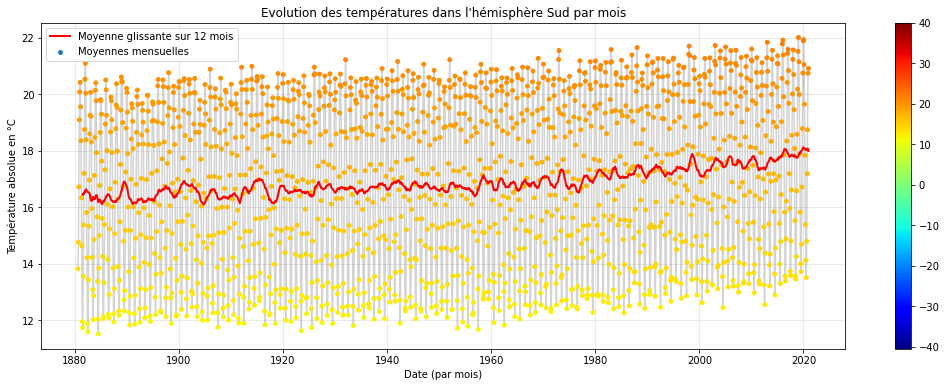

In [181]:
# Utilisation de la fonction get_plot_month pour le DF south_hem :

plot_month(south_hem, "Evolution des températures dans l'hémisphère Sud par mois")

On observe une distribution très différente des températures mensuelles d'un hémisphère à l'autre.

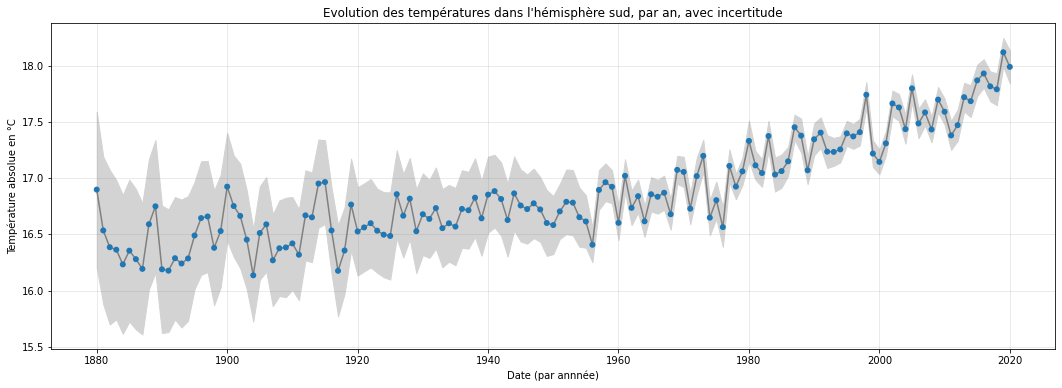

In [182]:
# plot_year pour le DF south_hem :

plot_year(south_hem, 
          "Evolution des températures dans l'hémisphère sud, par an, avec incertitude",
          show_uncert=True)

Même remarque concernant l'amincissement de la marge d'incertitude.

### Affichage comparé

Affichons côte-à-côte ces 2 graphes, sans l'incertitude :

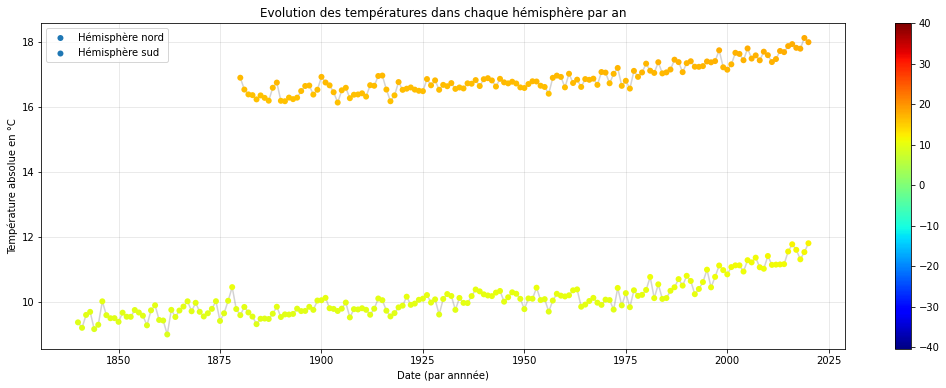

In [183]:
# Utilisation de la fonction mult_plot_year pour les DF north_hem et south_hem :

hems_dict = {"Hémisphère nord": north_hem, "Hémisphère sud": south_hem}
mult_plot_year(hems_dict, "Evolution des températures dans chaque hémisphère par an")

# Je cherche à différencier les couleurs dans la légende (qui sinon n'a pas d'intérêt)

A nouveau, 2 remarques :
* La tendance à la hausse est nette dans les 2 hémisphères.
* Les températures mesurées dans l'hémisphère sud maintiennent un écart positif de 6°C env. par rapport à l'hémisphère nord.
La raison de cet écart doit être un plus grand ensoleillement, la rotation de la terre autour de son axe, ou encore la différence de surface d'eau d'un hémisphère à l'autre.

### Aggrégation des données

Nous souhaitons avoir les deux hémisphères réunies dans un seul dataset.

In [184]:
south_hem['hem'] = 'south'
north_hem['hem'] = 'north'

hems = pd.concat([south_hem, north_hem], axis=0)
display(hems.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3857 entries, 0 to 2171
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3857 non-null   datetime64[ns]
 1   year         3857 non-null   int64         
 2   month        3857 non-null   int64         
 3   ano          3857 non-null   float64       
 4   uncert       3857 non-null   float64       
 5   abs          3857 non-null   float64       
 6   mov_average  3835 non-null   float64       
 7   hem          3857 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 271.2+ KB


None

In [185]:
hems.head()

,date,year,month,ano,uncert,abs,mov_average,hem
0,1880-08-15,1880,8,0.323,0.693,13.823,NaN,south
1,1880-09-15,1880,9,-0.712,0.653,14.768,NaN,south
2,1880-10-15,1880,10,-0.688,0.692,16.722,NaN,south
3,1880-11-15,1880,11,-0.206,0.696,19.094,NaN,south
4,1880-12-15,1880,12,-0.357,0.726,20.083,NaN,south


## Températures par pays



In [186]:
# Lecture des données par pays
temps_countries = pd.read_csv('/content/drive/MyDrive/data/berkeley_earth/all_countries_abs.csv')

temps_countries

,date,afghanistan,albania,algeria,andorra,angola,anguilla,antarctica,argentina,armenia,...,turkmenistan,uganda,ukraine,uruguay,uzbekistan,venezuela,vietnam,yemen,zambia,zimbabwe
0,1743-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1744-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1744-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1744-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1744-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,2020-08-15,26.295,24.017,34.687,21.719,22.385,NaN,-32.168,10.782,18.640,...,27.909,23.316,21.013,14.227,26.097,26.213,27.542,31.935,21.223,19.621
3260,2020-09-15,20.147,21.339,31.515,17.295,24.295,NaN,-29.611,13.377,18.195,...,21.670,23.241,17.703,14.295,19.067,26.577,27.299,30.132,24.183,22.638
3261,2020-10-15,12.916,14.932,25.514,11.254,25.356,NaN,-26.018,16.502,11.396,...,14.130,23.166,12.549,17.589,11.672,26.211,24.192,26.916,25.994,24.588
3262,2020-11-15,6.912,10.253,19.019,9.571,24.040,NaN,-17.661,19.850,4.856,...,6.378,23.889,3.711,21.023,2.563,25.973,23.688,24.141,25.317,25.934


In [187]:
temps_countries.isna().sum(axis=0)

date              0
afghanistan    1468
albania          15
algeria        1034
andorra          15
               ... 
venezuela      1099
vietnam        1180
yemen          1585
zambia         1703
zimbabwe       1633
Length: 171, dtype: int64

In [188]:
print("Température minimale jamais observée (à l'échelle d'un pays) :", temps_countries.min(numeric_only=True).min())
print("Température maximale jamais observée (à l'échelle d'un pays) :", temps_countries.max(numeric_only=True).max())

Température minimale jamais observée (à l'échelle d'un pays) : -40.349
Température maximale jamais observée (à l'échelle d'un pays) : 39.384


# Concaténation des Data Sets

Pour faciliter notre analyse nous concaténons par année et mois l’ensemble Data Sets que nous souhaitons analyser dans un unique DataFrame. Nous concatènerons également les données liées aux émissions de CO2 (et à la hausse du niveau des océans ?).